# Airfoil Design using Machine Learning
---
## Summary

__Code under construction...__

The design of mechanical systems is the foundation for nearly all physical engineering creations--- from simple structures like a kitchen table to complex systems such as a commercial aircraft. The development of these systems undergo a significant series of steps, beginning with defining initial specifications, generating, analyzing, and selecting the optimal solution, and finally testing and implementing this solution.

An example of this process is in the aerodynamic design of airplane wing structures. Airplane wings operate on the theory of flight, in which a wing will undergo a lift force and a drag force. In the development of a wing, an engineer or company will set a lift and drag requirement for the structure, which necessitates proper design and analysis procedures. 

Engineers rely on physics simulation and analysis tools to guide the work flow for meeting certain criteria. One such tool to simulate the lift and drag of an airplane is through Computational Fluid Dynamics (CFD). While these tools produce highly accurate models and results, simulations are computationally demanding, especially if an engineer is iterating through various designs with subtle tweaks between each one.

Rapidly evolving machine learning tools have unveiled new methods to predict the behavior of certain parameters. __Using lift results from CFD software, we investigated the prospect of using machine learning (ML) models to predict the performance (i.e. lift) of an airfoil depending on the airfoil's geometry and test environment.__

## Key questions explored
- Instead of running 100,000s of CFD simulations, can engineers train a ML model on a small number of CFD simulations to predict the lift of a wide variety of airfoil shapes? 
- If so, can they do it with high accuracy and be more time efficient than the usual approach? 

## Techniques used
- linear, ridge, lasso regression
- partial least squares regression
- regression trees, boosting, random forest
- neural networks
- bootstrap


## Key findings

![Test results for 5000 training samples](results_5000train.png)

- __Integrating ML modeling into the airfoil design workflow significantly reduces computation time and, depending on which type of ML modeling is used, may or may not sacrifice accuracy.__ This provides an additional degree of flexibility for design engineers who are worried about computation time. 
    - For design problems where a large range of potential shapes, Reynolds numbers, and angle of attacks need to be considered, but model accuracy is not imperative, it would be advantageous to use either a regression tree or neural net model. 
    - For problems with a more narrow range in design parameters, or when it is not possible to sacrifice model accuracy for computation time, using a Boosting model with a training set of 5,000 observations would be ideal. This will reduce computation in comparison to the brute force approach and, since the MAE is around 0.005, we can consider the error associated with this model to be acceptable.
- Regardless of training sample size, __boosting and random forest models had the lowest test MAE,__ while lasso had the highest. 


## Table of Contents

> ### Part 1. [Data creation](#data)
> ### Part 2. [Establish modeling procedure](#procedure)
> ### Part 3. [Create helper functions](#functions)
> ### Part 4. [Linear regression](#linreg)
> ### Part 5. [Ridge regression](#ridge)
> ### Part 6. [Lasso regression](#lasso)
> ### Part 7. [Decision Tree](#CART)
> ### Part 8. [Random Forest](#RF)
> ### Part 9. [Boosting](#boosting)
> ### Part 10. [Partial Least Squares](#PLS)
> ### Part 11. [Neural network](#neural)
> ### Part 12. [Results](#results)
> ### Part 13. [Discussion](#discussion)
---

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

---

<a id="data"></a>
### Part 1: Data creation

#### 1.1 Process for creating raw data
- The data used in this assignment was created in a previous aerodynamics design project using XFOIL CFD. 
- A total of 60,000 CFD simulations simulations were conducted for around 1,100 different airfoil designs, each tested using different angles of attack and Reynolds numbers. Each simulation returned several outputs characterizing fluid flow around the airfoil, including lift force and drag force. 
- Data from these simulation were stored in CSV files so they could be easily accessed within a programming environment like R or Python. Included in the CSV files were several numeric parameters which characterize the shape of the airfoil and the test enviornment.
- After compiling all the CFD simulations, the data was stored in Google Drive. To pull the data into R for processing, the Google Drive package was implemented. This code was able to pull the data from the Drive, extract the necessary feature parameters into a Data Frame, then delete the file from the computer so that excess data would not need to be stored locally. 
- To meet the project goal of using a small amount of data to accurately predict lift on wide variety of airfoils, a subset of the 60,000+ observations needed to be selected for training the ML models. To accomplish this, the original 60,000+ observations were randomly scrambled to create an even distribution of data. From that scrambled dataset, data was randomly sampled to create a test set with 5000 observations, and three different training sets with 1000, 5000, and 10000 observations, respectively. This process ensured that each training set would contain an accurate representation of the full dataset. Each ML model utilized the same datasets so that that their relative performance could be compared.

#### 1.2 Features and response variable
A total of 5 features were utilized in the ML to characterize the CFD simulations:
- Relating to airfoil geometry:
    1. bluntness of leading edge
    2. location of max thickness
    3. sharpness of trailing edge
- Relating to the test environment:
    4. Reynolds number of fluid flow
    5. angle of attack
    
The response variable was the lift coefficient of the airfoil.

#### 1.3 Extract data from excel files for ML modeling

In [2]:
# Training set with 1000 samples
df_train1000 = pd.read_excel('train_data.xlsx', sheet_name='Train 1000').drop(columns='Max_Thickness')
X_train1000 = df_train1000.loc[:, df_train1000.columns != 'CL']
y_train1000 = df_train1000[['CL']]

# Training set with 5000 samples
df_train5000 = pd.read_excel('train_data.xlsx', sheet_name='Train 5000').drop(columns='Max_Thickness')
X_train5000 = df_train5000.loc[:, df_train5000.columns != 'CL']
y_train5000 = df_train5000[['CL']]

# Training set with 10000 samples
df_train10000 = pd.read_excel('train_data.xlsx', sheet_name='Train 10000').drop(columns='Max_Thickness')
X_train10000 = df_train10000.loc[:, df_train10000.columns != 'CL']
y_train10000 = df_train10000[['CL']]

# Test set
df_test = pd.read_excel('test_data.xlsx').drop(columns='Max_Thickness')
X_test = df_test.loc[:, df_test.columns != 'CL']
y_test = df_test[['CL']]

#### 1.4 Normalize data 
Since the scale of the feature values vary significantly, I will normalize the data using `StandardScaler()` which transforms the data using $z = \dfrac{x - u}{s}$ where $u$ is the mean of the feature values, and $s$ is the standard deviation.

In [3]:
print("Preparing train/val sets...")

# create scaling object
X_scaler = StandardScaler()
X_train1000 = X_scaler.fit_transform(X_train1000)
X_train5000 = X_scaler.fit_transform(X_train5000)
X_train10000 = X_scaler.fit_transform(X_train10000)

X_test = X_scaler.fit_transform(X_test)
print(">> X_train and X_val normalized\n")

Preparing train/val sets...
>> X_train and X_val normalized



<a id="procedure"></a>
### Part 2: Establish modeling procedures

1. Define a model type (e.g. logistic regression, KNN, etc)

2. Identify hyperparameters to test using cross validation

3. Find best hyperparameters using `CV_with_GridSearch` function

4. Instantiate model using optimal hyperparameters found in Step 3

5. Fit model and calculate model accuracy on train and test data using `estimate_model_results` function. If interested, bootstrap accuracy confidence intervals by setting `boostrap_results=True`

6. Take note of the differences in accuracy, and methods.

<a id="functions"></a>
### Part 3: Create helper functions
To complete the procedures identified in Part 2, I will create three helper functions, found in Sections 3.1 - 3.3. 

#### 3.1 Hyperparameter selection via cross-validation

In [4]:
def CV_with_GridSearch(estimator, h_parameters, cv, X_train, y_train):
    """
    Finds optimal hyperparameters for given model using GridSearchCV.
    
    Keyword arguments:
    estimator (sklearn model) -- instantiated ML model (e.g. SVC())
    h_parameters (list of dicts) -- hyperparameters to test
                                        e.g [{'multi_class': ['ovr'],
                                              'C': [0.01, 0.1, 1]},
    cv (int) -- number of folds to use in cross validation
    
    Returns:
    best_params (dict) -- most optimal parameters based on CV
    """
    clf = GridSearchCV(estimator, h_parameters, scoring='neg_mean_absolute_error', cv=3)
    clf.fit(X_train, y_train)
    
    best_params = clf.best_params_
    print("Best parameters set found on development set:\n")
    print(best_params)
    print("\nGrid scores on training set:\n")

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    return best_params

#### 3.2 Model creation and validation results

In [5]:
def estimate_model_results(final_estimator, X_train, y_train, X_test, y_test, bootstrap_results=False):
    """
    Calculates train/test accuracy and the test MAE's
    upper/lower bounds using bootstrapping.
    
    Keyword arguments:
    final_estimator (sklearn model) -- instantiated ML model (e.g. SVC())
    bootstrap_results (boolean) -- bootstraps validation accuracy results
    
    Returns:
    final_estimator (sklearn model) -- trained ML model
    MAE_test (float) -- test MAE
    MAE_bounds (list) -- confidence intervals for test MAE
    """
    # Fit model to training data
    final_estimator.fit(X_train, y_train)    
    
    # Predict response variable for both train and test sets
    y_train_pred = final_estimator.predict(X_train)
    y_test_pred = final_estimator.predict(X_test)
    
    # Calculate MSE on train and test sets
    MAE_train = mean_absolute_error(y_train, y_train_pred)
    MAE_test = mean_absolute_error(y_test, y_test_pred)  
    
    print(f'RESULTS\n\nModel: {final_estimator}:\n\nTraining set size: {len(X_train)} samples\n----')
    print('Train MAE:', MAE_train)
    print('Test MAE:', MAE_test)
    if bootstrap_results:
        MAE_bounds = bootstrap_metrics(1000, 0.95, final_estimator, X_test, y_test)
    else:
        MAE_bounds = 0
    return final_estimator, MAE_test, MAE_bounds


#### 3.3 Confidence intervals of test results using bootstrapping

In [6]:
def bootstrap_metrics(num_iterations, alpha, model, X_test, y_test):
    """
    Calculates upper/lower bounds of accuracy using bootstrapping
    
    Keyword arguments:
    num_iterations (int) -- number of times to run bootstrap
    alpha (float) -- confidence interval (e.g. 0.95 means "95% confidence")
    model (sklearn model) -- pre trained model ready to predict
    X_test (pandas dataframe or ndarray) -- Test data 
    y_test (pandas dataframe/series or ndarray) -- Test response variable
    
    Returns:
    acc_bounds (list) - accuracy CI bounds using bootstrapping
    """
    stat_MAE = []
    X_test = pd.DataFrame(X_test)
    y_test = pd.DataFrame(y_test).reset_index()[['CL']]
    test_set = X_test.join(y_test, how = "outer")

    for i in range(num_iterations):
        test_sample = resample(test_set, n_samples=len(test_set))
        X_sample = test_sample.loc[:, test_sample.columns != 'CL']
        y_sample = test_sample[['CL']]
    
        # Calculate MAE
        y_pred_sample = model.predict(X_sample) 
        MAE = mean_absolute_error(y_sample, y_pred_sample)
        
        # Store scores in list
        stat_MAE.append(MAE)
    
    q_lower = ((1-alpha)/2) * 100
    q_upper = (alpha + ((1-alpha)/2)) * 100
    
    # Accuracy bounds
    MAE_lower = max(0, np.percentile(stat_MAE, q_lower))
    MAE_upper = min(1, np.percentile(stat_MAE, q_upper))
    print('\n{}% Confidence interval for test MAE = [{} and {}]'.format(alpha*100, MAE_lower, MAE_upper))

    MAE_bounds = [MAE_lower, MAE_upper]

    # Plot results
    plot_bootstrap_results(stat_MAE, MAE_bounds)
    

    return MAE_bounds

In [7]:
def plot_bootstrap_results(statistic, bounds):
    """
    Calculates upper/lower bounds of accuracy using bootstrapping
    
    Keyword arguments:
    num_iterations (int) -- number of times to run bootstrap
    alpha (float) -- confidence interval (e.g. 0.95 means "95% confidence")
    model (sklearn model) -- pre trained model ready to predict
    X_val (pandas dataframe or ndarray) -- Validation data 
    y_val (pandas dataframe/series or ndarray) -- Validation classes
    
    Returns:
        None
    """
    plt.figure(figsize=(4,4))
    plt.hist(statistic)
    plt.axvline(x=bounds[0], color='r', linestyle='--')
    plt.axvline(x=bounds[1], color='r', linestyle='--')

    plt.title("Bootstrap CI for MAE", fontsize=12)
    plt.xlabel("MAE", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.show()

<a id="linreg"></a>
### Part 4: Linear regression 

#### 4.1 Training on 1000 samples

RESULTS

Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False):

Training set size: 1000 samples
----
Train MAE: 0.026038162070105054
Test MAE: 0.027131963163592506

95.0% Confidence interval for test MAE = [0.026562969312268998 and 0.027695939908883496]


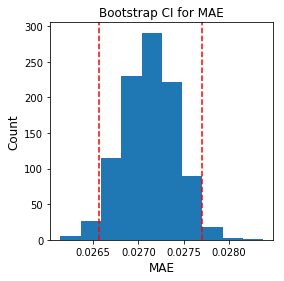

In [8]:
# Step 1
estimator = LinearRegression()

# Steps 2-4 not relevant

# Step 5
linear_model, MAE_test_linear, CI_ridge = estimate_model_results(
    estimator, X_train1000, y_train1000, X_test, y_test, bootstrap_results=True)

#### 4.2 Training on 5000 samples

RESULTS

Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False):

Training set size: 5000 samples
----
Train MAE: 0.026755625457139873
Test MAE: 0.027200994596369755

95.0% Confidence interval for test MAE = [0.02663489684203734 and 0.027742585534089294]


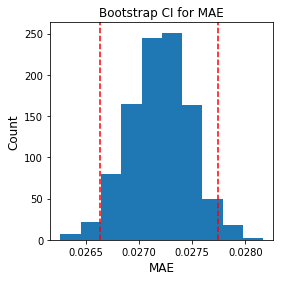

In [9]:
linear_model, MAE_test_linear, CI_ridge = estimate_model_results(
    estimator, X_train5000, y_train5000, X_test, y_test, bootstrap_results=True)

#### 4.3 Training on 10000 samples

RESULTS

Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False):

Training set size: 10000 samples
----
Train MAE: 0.026840902433327
Test MAE: 0.026938513715716324

95.0% Confidence interval for test MAE = [0.026387867708420196 and 0.027527344518118776]


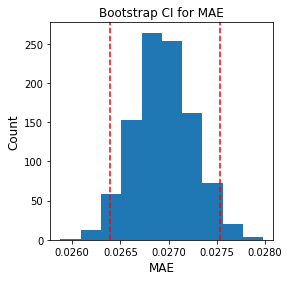

In [10]:
linear_model, MAE_test_linear, CI_ridge = estimate_model_results(
    estimator, X_train10000, y_train10000, X_test, y_test, bootstrap_results=True)

<a id="ridge"></a>
### Part 5: Ridge regression 

#### 5.1 Training on 1000 samples

In [11]:
# Step 1
estimator = Ridge()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-4,6)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train1000, y_train1000)

Best parameters set found on development set:

{'alpha': 0.01831563888873418}

Grid scores on training set:

-0.026 (+/-0.002) for {'alpha': 0.01831563888873418}
-0.026 (+/-0.002) for {'alpha': 0.049787068367863944}
-0.026 (+/-0.002) for {'alpha': 0.1353352832366127}
-0.026 (+/-0.002) for {'alpha': 0.36787944117144233}
-0.026 (+/-0.002) for {'alpha': 1.0}
-0.026 (+/-0.002) for {'alpha': 2.718281828459045}
-0.026 (+/-0.002) for {'alpha': 7.38905609893065}
-0.027 (+/-0.001) for {'alpha': 20.085536923187668}
-0.029 (+/-0.000) for {'alpha': 54.598150033144236}
-0.040 (+/-0.001) for {'alpha': 148.4131591025766}


RESULTS

Model: Ridge(alpha=0.01831563888873418, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001):

Training set size: 1000 samples
----
Train MAE: 0.02603812784618542
Test MAE: 0.027132014112904397

95.0% Confidence interval for test MAE = [0.026539135358422578 and 0.027732019779984612]


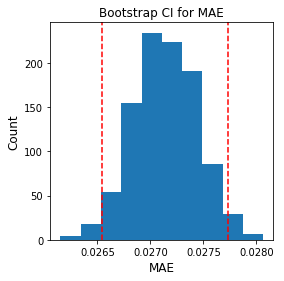

In [12]:
# Step 4
ridge_model = Ridge(alpha= best_params['alpha'])

# Step 5
ridge_model, MAE_test_ridge, CI_ridge = estimate_model_results(
    ridge_model, X_train1000, y_train1000, X_test, y_test, bootstrap_results=True)

#### 5.1 Training on 5000 samples

In [13]:
# Step 1
estimator = Ridge()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-4,8)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train5000, y_train5000)

Best parameters set found on development set:

{'alpha': 7.38905609893065}

Grid scores on training set:

-0.027 (+/-0.000) for {'alpha': 0.01831563888873418}
-0.027 (+/-0.000) for {'alpha': 0.049787068367863944}
-0.027 (+/-0.000) for {'alpha': 0.1353352832366127}
-0.027 (+/-0.000) for {'alpha': 0.36787944117144233}
-0.027 (+/-0.000) for {'alpha': 1.0}
-0.027 (+/-0.000) for {'alpha': 2.718281828459045}
-0.027 (+/-0.000) for {'alpha': 7.38905609893065}
-0.027 (+/-0.000) for {'alpha': 20.085536923187668}
-0.027 (+/-0.000) for {'alpha': 54.598150033144236}
-0.027 (+/-0.000) for {'alpha': 148.4131591025766}
-0.031 (+/-0.001) for {'alpha': 403.4287934927351}
-0.047 (+/-0.002) for {'alpha': 1096.6331584284585}


RESULTS

Model: Ridge(alpha=7.38905609893065, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001):

Training set size: 5000 samples
----
Train MAE: 0.026753479839131386
Test MAE: 0.027211628027772248

95.0% Confidence interval for test MAE = [0.026619658975804154 and 0.027808958785255283]


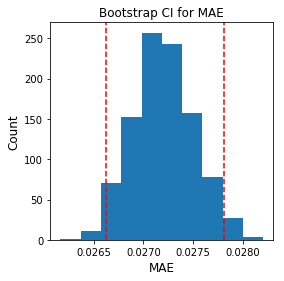

In [14]:
# Step 4
ridge_model = Ridge(alpha= best_params['alpha'])

# Step 5
ridge_model, MAE_test_ridge, CI_ridge = estimate_model_results(
    ridge_model, X_train5000, y_train5000, X_test, y_test, bootstrap_results=True)

#### 5.1 Training on 10000 samples

In [15]:
# Step 1
estimator = Ridge()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-4,8)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train10000, y_train10000)

Best parameters set found on development set:

{'alpha': 20.085536923187668}

Grid scores on training set:

-0.027 (+/-0.001) for {'alpha': 0.01831563888873418}
-0.027 (+/-0.001) for {'alpha': 0.049787068367863944}
-0.027 (+/-0.001) for {'alpha': 0.1353352832366127}
-0.027 (+/-0.001) for {'alpha': 0.36787944117144233}
-0.027 (+/-0.001) for {'alpha': 1.0}
-0.027 (+/-0.001) for {'alpha': 2.718281828459045}
-0.027 (+/-0.001) for {'alpha': 7.38905609893065}
-0.027 (+/-0.001) for {'alpha': 20.085536923187668}
-0.027 (+/-0.001) for {'alpha': 54.598150033144236}
-0.027 (+/-0.001) for {'alpha': 148.4131591025766}
-0.028 (+/-0.001) for {'alpha': 403.4287934927351}
-0.034 (+/-0.001) for {'alpha': 1096.6331584284585}


RESULTS

Model: Ridge(alpha=20.085536923187668, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001):

Training set size: 10000 samples
----
Train MAE: 0.026835587411905705
Test MAE: 0.026944755629168315

95.0% Confidence interval for test MAE = [0.02641136967673206 and 0.027519739633749565]


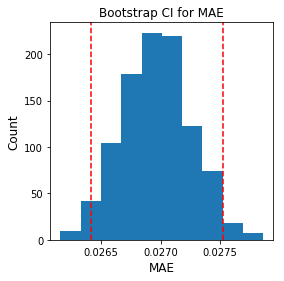

In [16]:
# Step 4
ridge_model = Ridge(alpha= best_params['alpha'])

# Step 5
ridge_model, MAE_test_ridge, CI_ridge = estimate_model_results(
    ridge_model, X_train10000, y_train10000, X_test, y_test, bootstrap_results=True)

<a id="lasso"></a>
### Part 6: Lasso regression 

#### 6.1 Training on 1000 samples

In [17]:
# Step 1
estimator = Lasso()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-8,0)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train1000, y_train1000)

Best parameters set found on development set:

{'alpha': 0.0009118819655545162}

Grid scores on training set:

-0.026 (+/-0.002) for {'alpha': 0.00033546262790251185}
-0.026 (+/-0.002) for {'alpha': 0.0009118819655545162}
-0.026 (+/-0.002) for {'alpha': 0.0024787521766663585}
-0.028 (+/-0.002) for {'alpha': 0.006737946999085467}
-0.038 (+/-0.002) for {'alpha': 0.01831563888873418}
-0.057 (+/-0.002) for {'alpha': 0.049787068367863944}
-0.125 (+/-0.003) for {'alpha': 0.1353352832366127}
-0.156 (+/-0.003) for {'alpha': 0.36787944117144233}


RESULTS

Model: Lasso(alpha=0.0009118819655545162, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False):

Training set size: 1000 samples
----
Train MAE: 0.025968101232298545
Test MAE: 0.02709667236460458

95.0% Confidence interval for test MAE = [0.026519758369530504 and 0.027723894511769976]


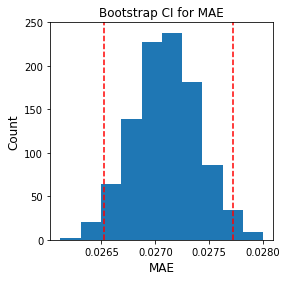

In [18]:
# Step 4
lasso_model = Lasso(alpha= best_params['alpha'])

# Step 5
lasso_model, MAE_test_lasso, CI_lasso = estimate_model_results(
    lasso_model, X_train1000, y_train1000, X_test, y_test, bootstrap_results=True)

#### 6.2 Training on 5000 samples

In [19]:
# Step 1
estimator = Lasso()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-8,0)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train5000, y_train5000)

Best parameters set found on development set:

{'alpha': 0.0009118819655545162}

Grid scores on training set:

-0.027 (+/-0.000) for {'alpha': 0.00033546262790251185}
-0.027 (+/-0.000) for {'alpha': 0.0009118819655545162}
-0.027 (+/-0.000) for {'alpha': 0.0024787521766663585}
-0.028 (+/-0.001) for {'alpha': 0.006737946999085467}
-0.038 (+/-0.002) for {'alpha': 0.01831563888873418}
-0.056 (+/-0.003) for {'alpha': 0.049787068367863944}
-0.123 (+/-0.003) for {'alpha': 0.1353352832366127}
-0.155 (+/-0.002) for {'alpha': 0.36787944117144233}


RESULTS

Model: Lasso(alpha=0.0009118819655545162, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False):

Training set size: 5000 samples
----
Train MAE: 0.026682431325179994
Test MAE: 0.02720101488946406

95.0% Confidence interval for test MAE = [0.02669404964531468 and 0.02778796797400843]


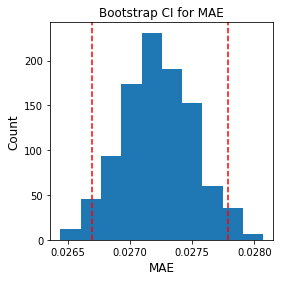

In [20]:
# Step 4
lasso_model = Lasso(alpha= best_params['alpha'])

# Step 5
lasso_model, MAE_test_lasso, CI_lasso = estimate_model_results(
    lasso_model, X_train5000, y_train5000, X_test, y_test, bootstrap_results=True)

#### 6.3 Training on 5000 samples

In [21]:
# Step 1
estimator = Lasso()

# Step 2
h_parameters = [{'alpha': [np.exp(i) for i in range(-8,0)]}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train10000, y_train10000)

Best parameters set found on development set:

{'alpha': 0.0009118819655545162}

Grid scores on training set:

-0.027 (+/-0.001) for {'alpha': 0.00033546262790251185}
-0.027 (+/-0.001) for {'alpha': 0.0009118819655545162}
-0.027 (+/-0.001) for {'alpha': 0.0024787521766663585}
-0.028 (+/-0.001) for {'alpha': 0.006737946999085467}
-0.038 (+/-0.002) for {'alpha': 0.01831563888873418}
-0.056 (+/-0.003) for {'alpha': 0.049787068367863944}
-0.123 (+/-0.006) for {'alpha': 0.1353352832366127}
-0.155 (+/-0.004) for {'alpha': 0.36787944117144233}


RESULTS

Model: Lasso(alpha=0.0009118819655545162, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False):

Training set size: 5000 samples
----
Train MAE: 0.026682431325179994
Test MAE: 0.02720101488946406

95.0% Confidence interval for test MAE = [0.0266418699855782 and 0.02779312733070548]


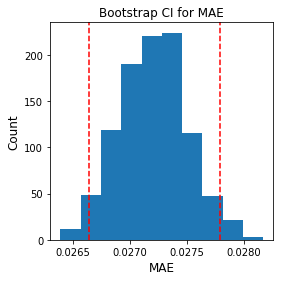

In [22]:
# Step 4
lasso_model = Lasso(alpha= best_params['alpha'])

# Step 5
lasso_model, MAE_test_lasso, CI_lasso = estimate_model_results(
    lasso_model, X_train5000, y_train5000, X_test, y_test, bootstrap_results=True)

<a id="RF"></a>
### Part 7: Random Forest

#### 7.1 Training on 1000 samples

In [23]:
# Step 1
estimator = RandomForestRegressor(n_estimators=100, random_state=10)

# Step 2
h_parameters = [{'max_features': range(1,5)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train1000, y_train1000)

Best parameters set found on development set:

{'max_features': 4}

Grid scores on training set:

-0.041 (+/-0.003) for {'max_features': 1}
-0.023 (+/-0.002) for {'max_features': 2}
-0.018 (+/-0.002) for {'max_features': 3}
-0.017 (+/-0.001) for {'max_features': 4}


In [24]:
# Step 4
RF = RandomForestRegressor(n_estimators=500, random_state=10, max_features=5)

# Step 5
RF_model, MAE_test_RF, CI_RF = estimate_model_results(
    RF, X_train1000, y_train1000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=None, oob_score=False, random_state=10,
           verbose=0, warm_start=False):

Training set size: 1000 samples
----
Train MAE: 0.005693639999999963
Test MAE: 0.01662230399999999


#### 7.2 Training on 5000 samples

In [25]:
# Step 1
estimator = RandomForestRegressor(n_estimators=100, random_state=10)

# Step 2
h_parameters = [{'max_features': range(1,5)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train5000, y_train5000)

Best parameters set found on development set:

{'max_features': 4}

Grid scores on training set:

-0.024 (+/-0.000) for {'max_features': 1}
-0.013 (+/-0.001) for {'max_features': 2}
-0.011 (+/-0.000) for {'max_features': 3}
-0.010 (+/-0.001) for {'max_features': 4}


In [26]:
# Step 4
RF = RandomForestRegressor(n_estimators=500, random_state=10, max_features=4)

# Step 5
RF_model, MAE_test_RF, CI_RF = estimate_model_results(
    RF, X_train5000, y_train5000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=None, oob_score=False, random_state=10,
           verbose=0, warm_start=False):

Training set size: 5000 samples
----
Train MAE: 0.0034007439999999833
Test MAE: 0.010151239999999976


#### 7.3 Training on 10000 samples

In [27]:
# Step 1
estimator = RandomForestRegressor(n_estimators=100, random_state=10)

# Step 2
h_parameters = [{'max_features': range(1,5)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train10000, y_train10000)

Best parameters set found on development set:

{'max_features': 4}

Grid scores on training set:

-0.018 (+/-0.001) for {'max_features': 1}
-0.011 (+/-0.000) for {'max_features': 2}
-0.009 (+/-0.000) for {'max_features': 3}
-0.009 (+/-0.000) for {'max_features': 4}


In [28]:
# Step 4
RF = RandomForestRegressor(n_estimators=500, random_state=10, max_features=4)

# Step 5
RF_model, MAE_test_RF, CI_RF = estimate_model_results(
    RF, X_train10000, y_train10000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=None, oob_score=False, random_state=10,
           verbose=0, warm_start=False):

Training set size: 10000 samples
----
Train MAE: 0.002771088000000002
Test MAE: 0.008068599999999947


<a id="CART"></a>
### Part 8: Decision Tree

#### 8.1 Training on 1000 samples

In [29]:
# Step 1
estimator = DecisionTreeRegressor(min_samples_leaf=5, random_state=10)

# Step 2
h_parameters = [{'min_impurity_decrease': np.linspace(0,0.01, 11)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train1000, y_train1000)

Best parameters set found on development set:

{'min_impurity_decrease': 0.0}

Grid scores on training set:

-0.024 (+/-0.003) for {'min_impurity_decrease': 0.0}
-0.050 (+/-0.003) for {'min_impurity_decrease': 0.001}
-0.050 (+/-0.003) for {'min_impurity_decrease': 0.002}
-0.074 (+/-0.019) for {'min_impurity_decrease': 0.003}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.004}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.005}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.006}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.007}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.008}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.009000000000000001}
-0.080 (+/-0.002) for {'min_impurity_decrease': 0.01}


In [30]:
# Step 4
CART_model = DecisionTreeRegressor(min_samples_leaf=5, random_state=10)

# Step 5
CART_model, MAE_test_CART, CI_CART = estimate_model_results(
    CART_model, X_train1000, y_train1000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=10, splitter='best'):

Training set size: 1000 samples
----
Train MAE: 0.012834015873015872
Test MAE: 0.021740847619047616


#### 8.2 Training on 5000 samples

In [31]:
# Step 1
estimator = DecisionTreeRegressor(min_samples_leaf=5, random_state=10)

# Step 2
h_parameters = [{'min_impurity_decrease': np.linspace(0,0.01, 11)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train5000, y_train5000)

Best parameters set found on development set:

{'min_impurity_decrease': 0.0}

Grid scores on training set:

-0.015 (+/-0.000) for {'min_impurity_decrease': 0.0}
-0.050 (+/-0.001) for {'min_impurity_decrease': 0.001}
-0.050 (+/-0.001) for {'min_impurity_decrease': 0.002}
-0.069 (+/-0.017) for {'min_impurity_decrease': 0.003}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.004}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.005}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.006}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.007}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.008}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.009000000000000001}
-0.082 (+/-0.002) for {'min_impurity_decrease': 0.01}


In [32]:
# Step 4
CART_model = DecisionTreeRegressor(min_samples_leaf=5, random_state=10)

# Step 5
CART_model, MAE_test_CART, CI_CART = estimate_model_results(
    CART_model, X_train5000, y_train5000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=10, splitter='best'):

Training set size: 5000 samples
----
Train MAE: 0.008430158730158739
Test MAE: 0.014257552380952387


#### 8.3 Training on 10000 samples

In [33]:
# Step 1
estimator = DecisionTreeRegressor(min_samples_leaf=5, random_state=10)

# Step 2
h_parameters = [{'min_impurity_decrease': np.linspace(0,0.01, 11)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train10000, y_train10000)

Best parameters set found on development set:

{'min_impurity_decrease': 0.0}

Grid scores on training set:

-0.013 (+/-0.000) for {'min_impurity_decrease': 0.0}
-0.049 (+/-0.001) for {'min_impurity_decrease': 0.001}
-0.049 (+/-0.001) for {'min_impurity_decrease': 0.002}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.003}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.004}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.005}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.006}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.007}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.008}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.009000000000000001}
-0.081 (+/-0.000) for {'min_impurity_decrease': 0.01}


In [34]:
# Step 4
CART_model = DecisionTreeRegressor(random_state=10)

# Step 5
CART_model, MAE_test_CART, CI_CART = estimate_model_results(
    CART_model, X_train10000, y_train10000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=10, splitter='best'):

Training set size: 10000 samples
----
Train MAE: 1.7892284875919983e-17
Test MAE: 0.010964000000000014


<a id="boosting"></a>
### Part 9: Boosting
#### 9.1 Training on 1000 samples

In [35]:
# Step 1
estimator = GradientBoostingRegressor(n_estimators=500, random_state=10)

# Step 2
h_parameters = [{'max_depth': np.linspace(1,10,10)}]

# Step 3
best_params = CV_with_GridSearch(estimator, h_parameters, 10, X_train1000, y_train1000)

Best parameters set found on development set:

{'max_depth': 4.0}

Grid scores on training set:

-0.025 (+/-0.001) for {'max_depth': 1.0}
-0.016 (+/-0.001) for {'max_depth': 2.0}
-0.014 (+/-0.002) for {'max_depth': 3.0}
-0.013 (+/-0.002) for {'max_depth': 4.0}
-0.013 (+/-0.002) for {'max_depth': 5.0}
-0.015 (+/-0.002) for {'max_depth': 6.0}
-0.017 (+/-0.003) for {'max_depth': 7.0}
-0.018 (+/-0.003) for {'max_depth': 8.0}
-0.020 (+/-0.003) for {'max_depth': 9.0}
-0.022 (+/-0.002) for {'max_depth': 10.0}


In [36]:
# Step 4
GBC_model = GradientBoostingRegressor(n_estimators=500, random_state=10)

# Step 5
GBC_model, MAE_test_GBC, CI_GBC = estimate_model_results(
    GBC_model, X_train1000, y_train1000, X_test, y_test, bootstrap_results=False)

RESULTS

Model: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=10, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False):

Training set size: 1000 samples
----
Train MAE: 0.0057582589811360696
Test MAE: 0.012176176204996978


<a id="PLS"></a>
### Part 10: Partial Least Squares

The goal of partial least squares is to identify linear combinations that best represent the original features. PLS is a supervised learning alternative to PCR. This is a dimensionality reduction technique with the aim of reducing the number of features to a more management number while still retaining "most" of the "patterns in the data. 

While in the previous models my goal was to find hyperparameters that minimized MAE using `CV_with_GridSearch`, PLS's motive is slightly different. Thus I don't use Step 1-3, as I did previously.

#### Visualize impact of components on error

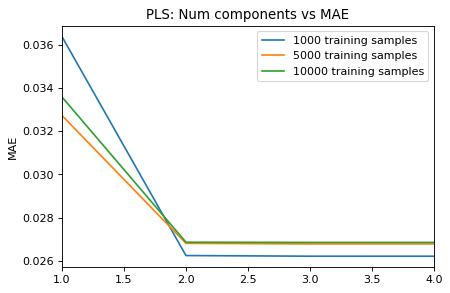

In [37]:
# Steps 1-3 - not relevant

PLS_mae1000, PLS_mae5000, PLS_mae10000  = [], [], []

# Run PLS with different numbers of components
for i in np.arange(1, 5):
    pls_CV = PLSRegression(n_components=i) 
    score1000 = -1*cross_val_score(pls_CV, X_train1000, y_train1000, cv=5, scoring='neg_mean_absolute_error').mean()
    score5000 = -1*cross_val_score(pls_CV, X_train5000, y_train5000, cv=5, scoring='neg_mean_absolute_error').mean()
    score10000 = -1*cross_val_score(pls_CV, X_train10000, y_train10000, cv=5, scoring='neg_mean_absolute_error').mean()
    PLS_mae1000.append(score1000)
    PLS_mae5000.append(score5000)
    PLS_mae10000.append(score10000)

# Plot results
plt.figure(num=1, figsize=(6,4), dpi=80, facecolor='w', edgecolor='k')
plt.title('PLS: Num components vs MAE')

plt.plot(np.arange(1, 5), np.array(PLS_mae1000), label='1000 training samples')
plt.plot(np.arange(1, 5), np.array(PLS_mae5000), label='5000 training samples')
plt.plot(np.arange(1, 5), np.array(PLS_mae10000), label='10000 training samples')
plt.xlim([1,4])
plt.legend()
plt.ylabel('MAE')
plt.show()

It looks like I can use 2 components with only marginal increases in error.

#### 10.1 Training on 1000 samples

RESULTS

Model: Lasso(alpha=0.0009118819655545162, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False):

Training set size: 1000 samples
----
Train MAE: 0.025968101232298545
Test MAE: 0.02709667236460458

95.0% Confidence interval for test MAE = [0.02648903739428075 and 0.02767432115083583]


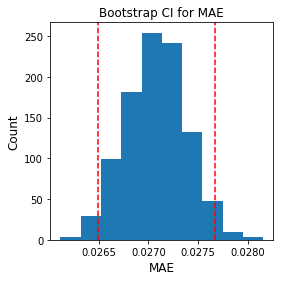

In [38]:
# Step 4
PLS_model = PLSRegression(n_components= 2)

# Step 5
PLS_model, MAE_test_PLS, CI_PLS = estimate_model_results(
    lasso_model, X_train1000, y_train1000, X_test, y_test, bootstrap_results=True)

#### 10.2 Training on 5000 samples

RESULTS

Model: Lasso(alpha=0.0009118819655545162, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False):

Training set size: 5000 samples
----
Train MAE: 0.026682431325179994
Test MAE: 0.02720101488946406

95.0% Confidence interval for test MAE = [0.026645673308945513 and 0.02780218577989313]


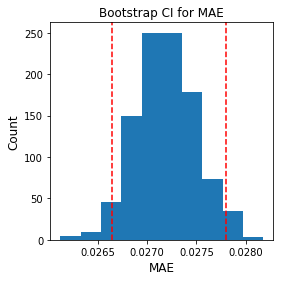

In [39]:
# Step 4
PLS_model = PLSRegression(n_components= 2)

# Step 5
PLS_model, MAE_test_PLS, CI_PLS = estimate_model_results(
    lasso_model, X_train5000, y_train5000, X_test, y_test, bootstrap_results=True)

#### 10.3 Training on 10000 samples

RESULTS

Model: Lasso(alpha=0.0009118819655545162, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False):

Training set size: 10000 samples
----
Train MAE: 0.026755345412479602
Test MAE: 0.02691651094748569

95.0% Confidence interval for test MAE = [0.026366776983789798 and 0.02750178770206209]


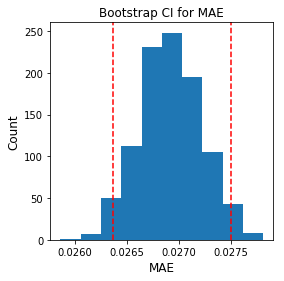

In [40]:
# Step 4
PLS_model = PLSRegression(n_components= 2)

# Step 5
PLS_model, MAE_test_PLS, CI_PLS = estimate_model_results(
    lasso_model, X_train10000, y_train10000, X_test, y_test, bootstrap_results=True)

# Under construction...